# Load Dataset

In [11]:
import pandas as pd
df = pd.read_csv('train_data.txt', sep=':::', header=None, engine='python')
df = df.drop(0, axis=1)
df.columns = ['name', 'class', 'description']
df.head()

,name,class,description
0,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
1,Cupid (1997),thriller,A brother and sister with a past incestuous r...
2,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
3,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
4,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


# Downsampling

In [12]:
# Cap the number of rows per class to 1000
df = df.groupby('class').head(10).reset_index(drop=True) # 2000

df['class'].value_counts()

class
 drama           10
 music           10
 musical         10
 game-show       10
 romance         10
 biography       10
 news            10
 history         10
 mystery         10
 family          10
 western         10
 talk-show       10
 adventure       10
 sci-fi          10
 thriller        10
 short           10
 fantasy         10
 action          10
 animation       10
 sport           10
 horror          10
 reality-tv      10
 crime           10
 comedy          10
 documentary     10
 adult           10
 war             10
Name: count, dtype: int64

# Add category id

In [13]:
# Create a new column 'category_id' with encoded categories
df['category_id'] = df['class'].factorize()[0]
category_id_df = df[['class', 'category_id']].drop_duplicates()


# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'class']].values)

# New dataframe
df.head()

,name,class,description,category_id
0,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,0
1,Cupid (1997),thriller,A brother and sister with a past incestuous r...,1
2,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,2
3,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,0
4,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,0


# Test - Train split

In [14]:
from sklearn.model_selection import train_test_split

X = df['description']
y = df['category_id']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 20)

# Create Embedding Generator

In [15]:
from transformers import RobertaTokenizer, RobertaModel
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaModel.from_pretrained('roberta-base')

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
import torch

def iter_data(inputs, outputs, batch_size):
  n = inputs.shape[0]
  idx = torch.randperm(n) # to have a random batch
  for i in range(0, n, batch_size):
    batch_idx = idx[i:i+batch_size]
    encoded_input = tokenizer(inputs[batch_idx].tolist(), return_tensors='pt', padding=True, truncation=True)
    output = model(**encoded_input)
    batch = output.pooler_output, torch.from_numpy(outputs[batch_idx])
    yield batch # generator

# Classification

In [17]:
import torch.nn as nn
mlp_model = nn.Sequential(
    nn.Linear(768, 27, bias=True),
    nn.ReLU()
)

In [18]:
import torch.optim as optim

loss_func = nn.CrossEntropyLoss()

optimizer = optim.SGD(mlp_model.parameters(), lr=0.01)

max_epochs = 1
losses = []
iteration = 0

for epoch in range(max_epochs):
  for batch in iter_data(X_train.to_numpy(), y_train.to_numpy(), 8):
    x_batch, y_batch = batch
    preds = mlp_model(x_batch) # predictions
    loss = loss_func(preds, y_batch)
    optimizer.zero_grad()
    loss.backward() # get gradients
    optimizer.step()
    iteration += 1
    print(f"iteration: {iteration}/{int(len(y_train) / 5.0)} loss: {loss.item()}")
    losses.append(loss.item()) # extract from tensor a scalar

iteration: 1/40 loss: 3.281254768371582
iteration: 2/40 loss: 3.268577814102173
iteration: 3/40 loss: 3.223144054412842
iteration: 4/40 loss: 3.314711809158325
iteration: 5/40 loss: 3.3127288818359375
iteration: 6/40 loss: 3.2680482864379883
iteration: 7/40 loss: 3.274035930633545
iteration: 8/40 loss: 3.315958261489868
iteration: 9/40 loss: 3.2820684909820557
iteration: 10/40 loss: 3.24096417427063
iteration: 11/40 loss: 3.3598339557647705
iteration: 12/40 loss: 3.3222508430480957
iteration: 13/40 loss: 3.2869019508361816
iteration: 14/40 loss: 3.283547878265381
iteration: 15/40 loss: 3.2925710678100586
iteration: 16/40 loss: 3.3875694274902344
iteration: 17/40 loss: 3.3388829231262207
iteration: 18/40 loss: 3.3568296432495117
iteration: 19/40 loss: 3.3066036701202393
iteration: 20/40 loss: 3.3380064964294434
iteration: 21/40 loss: 3.2967827320098877
iteration: 22/40 loss: 3.349731206893921
iteration: 23/40 loss: 3.2806570529937744
iteration: 24/40 loss: 3.344357490539551
iteration: 2

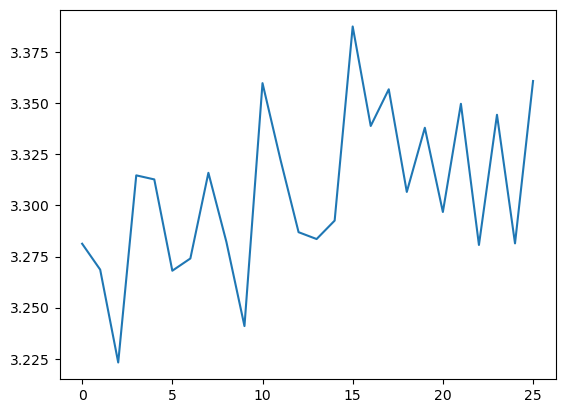

In [21]:
import matplotlib.pyplot as plt

plt.plot(losses)

# Evaluation

In [22]:
acc_sum = 0

for batch in iter_data(X_test.to_numpy(), y_test.to_numpy(), 5):
  x_batch, y_batch = batch
  preds = mlp_model(x_batch)
  label_pred = torch.argmax(preds, dim=1)
  test_acc = torch.sum(label_pred == y_batch)
  acc_sum += test_acc
  print(f"tmp Accuracy: {test_acc / 5.0}")

print(f"total Accuracy: {acc_sum / float(len(y_test))}")

tmp Accuracy: 0.0
tmp Accuracy: 0.20000000298023224
tmp Accuracy: 0.0
tmp Accuracy: 0.0
tmp Accuracy: 0.0
tmp Accuracy: 0.0
tmp Accuracy: 0.0
tmp Accuracy: 0.0
tmp Accuracy: 0.0
tmp Accuracy: 0.0
tmp Accuracy: 0.0
tmp Accuracy: 0.20000000298023224
tmp Accuracy: 0.0
tmp Accuracy: 0.0
total Accuracy: 0.029411764815449715
